<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Порядок действий:
- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

Постройте и обучите свёрточную нейронную сеть на датасете с фотографиями людей. Добейтесь значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator
)
import tensorflow.keras

In [5]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


В выборке 7 тысяч фотографий.

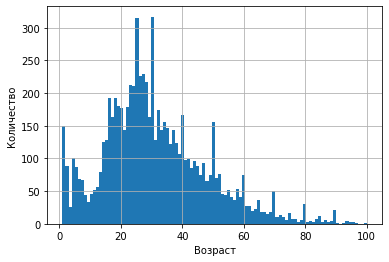

In [6]:
labels.real_age.hist(bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

В выборке больше всего людей от 18 до 35 лет.

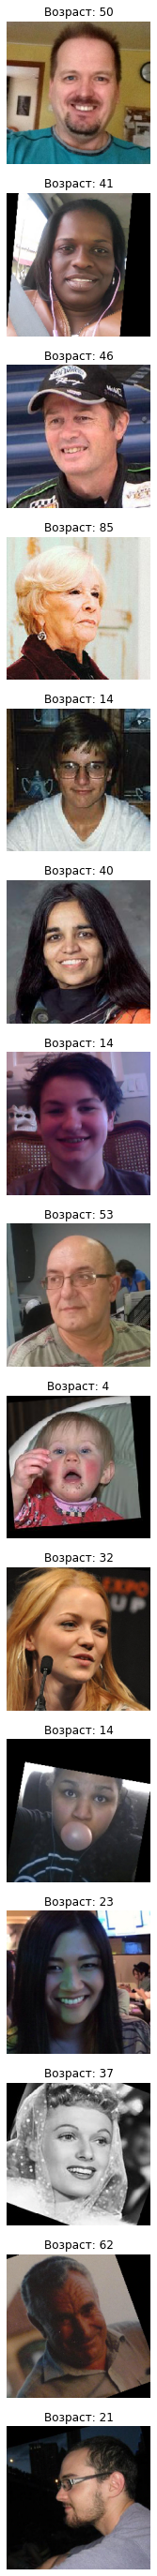

In [7]:
images, labels = next(train_gen_flow)

plt.figure(figsize=(50, 50))
for i in range(15):
    plt.subplot(15, 1, i + 1)
    plt.imshow(images[i])
    plt.title(f"Возраст: {labels[i]}")
    plt.axis('off')
plt.show()

Датасет состоит из фотографией с подписями с возрастом к каждой. Лица людей показаны в очень разных состояниях, все смотрят в разные стороны, голова повернута по-разному, лица с разным масштабом, из-за чего сложно будет максимально точно обучить модель.

Для аугментации будем использовать параметр для горизонтального отражения изображения, таким образом объектов в датасете станет больше за счет создания новых фотографий.

## Обучение модели

```python

def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        horizontal_flip=True
    )
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        batch_size=16,
        subset='training',
        seed=12345)
    return train_datagen_flow


def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255
    )
    val_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        batch_size=16,
        subset='validation',
        seed=12345)
    return val_datagen_flow


def create_model(input_shape):
    backbone = tensorflow.keras.applications.resnet.ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = tensorflow.keras.models.Sequential([
        backbone,
        tensorflow.keras.layers.GlobalAveragePooling2D(),
        tensorflow.keras.layers.Dense(512, activation='relu'),
        tensorflow.keras.layers.Dense(1, activation='linear')
    ])

    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True
    )

    return model

```

```

Train for 380 steps, validate for 95 steps
Epoch 1/5
2025-04-21 21:09:49.401441: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-04-21 21:09:49.849294: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 66s - loss: 175.7841 - mae: 9.8035 - val_loss: 370.3671 - val_mae: 14.2167
Epoch 2/5
380/380 - 53s - loss: 61.2279 - mae: 5.9748 - val_loss: 130.3998 - val_mae: 8.5646
Epoch 3/5
380/380 - 54s - loss: 31.7330 - mae: 4.3785 - val_loss: 68.8584 - val_mae: 6.2357
Epoch 4/5
380/380 - 53s - loss: 18.8429 - mae: 3.3313 - val_loss: 73.8194 - val_mae: 6.4112
Epoch 5/5
380/380 - 53s - loss: 14.0598 - mae: 2.8513 - val_loss: 73.5936 - val_mae: 6.6384
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 10s - loss: 73.5936 - mae: 6.6384

```

Достингуто нужное значение MAE, а именно 6.63 (<8). Это означает, что разработанная модель предсказывает возраст человека на фотографии с погрешностью в 6 лет.

## Анализ обученной модели

В датасете было 7000 фото. Больше всего людей в возрасте от 18 до 35 лет. Люди на фото с разным выражением лица, поворотом головы и освещением, что усложняет задачу. Обучена модель, которая по фотографии определяет возраст человека. Средняя ошибка получилась 6.63 года — это меньше допустимых 8, значит модель работает хорошо.